In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import pickle as cPickle
import tensorflow as tf
import time
import seaborn as sns
from sklearn.multiclass import OneVsOneClassifier

# Data source and information

The CIFAR10 dataset from (https://www.cs.toronto.edu/~kriz/cifar.html) is split into five training batches and one test batch, each of which contains 10,000 pictures. The test batch comprises exactly 1000 photographs from each class that were chosen at random. The remaining photos are distributed in random order in the training batches, though certain training batches may contain more photos from one class than another. The training batches each include exactly 5000 images.

# Data Loading ,exploration and preparation


Since the dataset is delivered as six Python "pickled" object produced with cPickle. To utilize them, we must first serialize them with pickle. load() taken from https://www.cs.toronto.edu/~kriz/cifar.html which returns a dictionary, then we need to put them in a single large numpy array :


In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [3]:
# unpickling the categories/classes 
categories = unpickle('batches.meta')

The list of classes/categores is stored in 'batches.meta' file which is unpickled above ,after unpickling we need to get the "label_names"of the dataset. The numeric label for each element corresponds to index of the element's label in the list of classes.

In [4]:
# saving the label names into categories variables
categories=categories['label_names']


In [5]:
# checking the variable categories
categories

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
# unpickling all batch files of the traning set
train_batch1=unpickle('data_batch_1')
train_batch2=unpickle('data_batch_2')
train_batch3=unpickle('data_batch_3')
train_batch4=unpickle('data_batch_4')
train_batch5=unpickle('data_batch_5')

In [7]:
# saving it to the given variables.
train_b1=train_batch1['data']
train_b2=train_batch2['data']
train_b3=train_batch3['data']
train_b4=train_batch4['data']
train_b5=train_batch5['data']

# getting the labels of each batches 
batch1_labels=train_batch1['labels']
batch2_labels=train_batch2['labels']
batch3_labels=train_batch3['labels']
batch4_labels=train_batch4['labels']
batch5_labels=train_batch5['labels']

In order to display the images, we need to reshape the data from its original row vector of 3072 into a colour image of 32x32 pixels we need to reshape the data. If we calculate 32*32*3 == 3072, the row vector for an image has the same number of elements. There are two processes involved in reshaping the row vector into (width x height x num channel) form. The first step is to utilize the reshape function ,followed by the transpose function as below.

In [8]:
# reshaping and connverting data type to float for computation.
def reshaping(data):
    data=data.reshape(10000,3,32,32).transpose(0,2,3,1).astype("float")
    return data

In [9]:
# reshaping the batches of train_set
x_train1=reshaping(train_b1)
x_train2=reshaping(train_b2)
x_train3=reshaping(train_b3)
x_train4=reshaping(train_b4)
x_train5=reshaping(train_b5)

In [10]:
# checking the shape of each batch
print('Training batch1 shape:',x_train1.shape)
print('Training batch2 shape:',x_train2.shape)
print('Training batch3 shape:',x_train3.shape)
print('Training batch4 shape:',x_train4.shape)
print('Training batch5 shape:',x_train5.shape)


Training batch1 shape: (10000, 32, 32, 3)
Training batch2 shape: (10000, 32, 32, 3)
Training batch3 shape: (10000, 32, 32, 3)
Training batch4 shape: (10000, 32, 32, 3)
Training batch5 shape: (10000, 32, 32, 3)


In [11]:
# combining all these five batches of data and labels
X_train=np.concatenate((x_train1,x_train2,x_train3,x_train4,x_train5),axis=0)
y_train=np.concatenate((batch1_labels,batch2_labels,batch3_labels,batch4_labels,batch5_labels),axis=0)
# shapes of train set data and labels
print("shape of the Xtrain set :",X_train.shape)
print("Shape of the Ytrain set lables ",y_train.shape)
print(X_train[0])

shape of the Xtrain set : (50000, 32, 32, 3)
Shape of the Ytrain set lables  (50000,)
[[[ 59.  62.  63.]
  [ 43.  46.  45.]
  [ 50.  48.  43.]
  ...
  [158. 132. 108.]
  [152. 125. 102.]
  [148. 124. 103.]]

 [[ 16.  20.  20.]
  [  0.   0.   0.]
  [ 18.   8.   0.]
  ...
  [123.  88.  55.]
  [119.  83.  50.]
  [122.  87.  57.]]

 [[ 25.  24.  21.]
  [ 16.   7.   0.]
  [ 49.  27.   8.]
  ...
  [118.  84.  50.]
  [120.  84.  50.]
  [109.  73.  42.]]

 ...

 [[208. 170.  96.]
  [201. 153.  34.]
  [198. 161.  26.]
  ...
  [160. 133.  70.]
  [ 56.  31.   7.]
  [ 53.  34.  20.]]

 [[180. 139.  96.]
  [173. 123.  42.]
  [186. 144.  30.]
  ...
  [184. 148.  94.]
  [ 97.  62.  34.]
  [ 83.  53.  34.]]

 [[177. 144. 116.]
  [168. 129.  94.]
  [179. 142.  87.]
  ...
  [216. 184. 140.]
  [151. 118.  84.]
  [123.  92.  72.]]]


In [12]:
# test set unpickle 
test_batch=unpickle('test_batch')
X_test_batch=test_batch["data"]
y_test=test_batch['labels']
X_test1=reshaping(X_test_batch)
# shapes of test set data and labels
print("shape of the Xtest set :",X_test1.shape)
print("Shape of the Ytest set lables ",np.shape(y_test))


shape of the Xtest set : (10000, 32, 32, 3)
Shape of the Ytest set lables  (10000,)


### Data Exploration

Exploring the distribution of each class within the training and test set as can be seen below each class has exactly 6000 samples ( 5000 for training and 1000 for the test). It is important to have equal distribution within all these 10 categories/classes. The graph below is highly crucial for training; for example, if we only had 1000 examples of label 1, the model would have difficulty detecting label 1 hence would result in "less accuracy," which is not going to happen because every class appears to be equal.

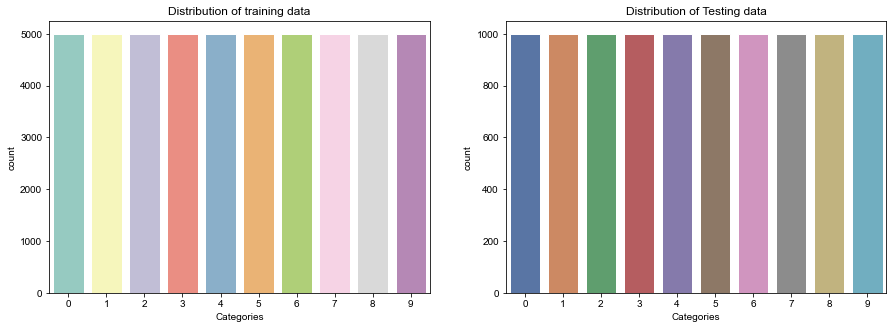

In [13]:

fig, axs = plt.subplots(1,2,figsize=(15,5)) 
sns.set_theme(style="darkgrid")
# Count plot for training set
sns.countplot(x=y_train, ax=axs[0],palette="Set3")
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Categories')
# Count plot for testing set
sns.countplot(x=y_test, ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Categories')
plt.show()

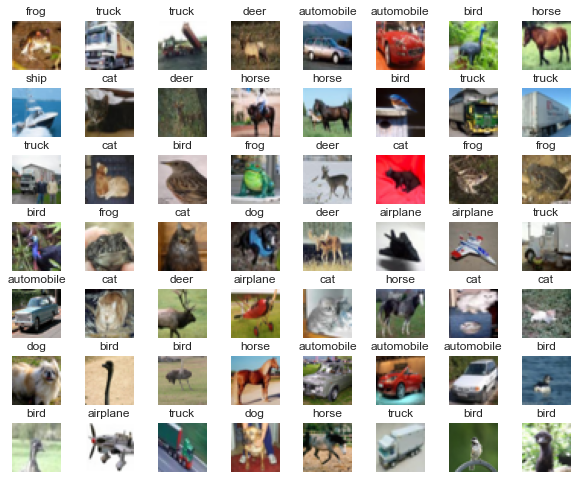

In [14]:
# checking the 56 images of training set
fig = plt.figure(figsize=(10,10))
for i in range(56):
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(X_train[i].astype('uint8'), cmap = plt.cm.bone)
    plt.title(categories[y_train[i]])
    plt.axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=-0.1)

plt.show()

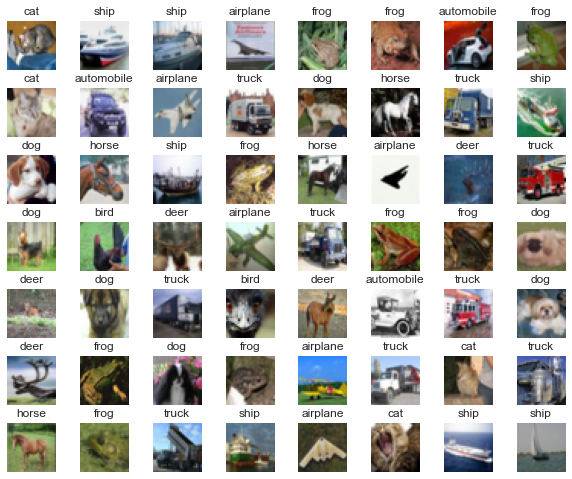

In [15]:
# checking the 56 images of test set
fig = plt.figure(figsize=(10,10))
for i in range(56):
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(X_test1[i].astype('uint8'), cmap = plt.cm.bone)
    plt.title(categories[y_test[i]])
    plt.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=-0.1)

plt.show()

In order to Normalize the pixel/channels values to range [0,1].we need to first transform the data type from unsigned integers to floats, and then dividing the data by 255 simply rescales the data from 0-255 to 0-1. (Converting it to float from int makes computation convenient too) which is called Normalizing your data ,it is a common procedure before feeding it to any machine learning algorithm .

In [16]:
# Reshaping both training and test data from channel to rows
X_train = np.reshape(X_train, (X_train.shape[0], -1)) # The -1 means that the corresponding dimension is calculated from the other given dimensions.
X_test = np.reshape(X_test1, (X_test1.shape[0], -1))
print(X_train.shape) 
print(X_train[0])

(50000, 3072)
[ 59.  62.  63. ... 123.  92.  72.]


In [17]:
# #Normalizing by dividing it to 255
X_train /= 255
X_test /= 255
print(X_train.shape)
print(X_train[0])

(50000, 3072)
[0.23137255 0.24313725 0.24705882 ... 0.48235294 0.36078431 0.28235294]


In [18]:
print(" Train shape :",X_train.shape)
print(" Test shape :",X_test.shape)

 Train shape : (50000, 3072)
 Test shape : (10000, 3072)


# Model Development

## Feature Engineering

PCA is a linear dimensionality reduction approach that can be used to extract information from a high-dimensional space by projecting it onto a lower-dimensional sub-space. It attempts to keep the vital elements of the data that have the most variation and delete the non-essential sections that have the least variance.Dimensions are simply features that represent data.For example,our dataset is a 32x32 image includes 60000 picture elements (pixels)(both training and test set) that are the dimensions or attributes that together represent that image(Sharma, 2020).

In [19]:
%%time
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_train)


CPU times: user 2min 55s, sys: 7.71 s, total: 3min 3s
Wall time: 1min


array([[-6.40101763e+00,  2.72903876e+00,  1.50171052e+00, ...,
        -7.62287826e-04, -1.16359323e-03, -3.49768400e-04],
       [ 8.29783385e-01, -9.49943219e-01,  6.00375260e+00, ...,
         1.08434589e-04,  5.76715387e-04, -7.71005927e-04],
       [ 7.73019978e+00, -1.15221023e+01, -2.75362051e+00, ...,
        -1.04460109e-03, -2.14105740e-04, -3.93469526e-04],
       ...,
       [ 7.07346587e-01, -1.13425212e+01, -3.93914878e-01, ...,
        -3.80341568e-04,  1.86432348e-03,  1.44785229e-03],
       [ 1.13679090e+01, -3.37597765e+00,  5.56619766e+00, ...,
        -4.67096832e-04,  7.44972963e-04, -1.67065056e-03],
       [ 4.19279645e+00, -1.18418848e+00, -4.44596297e+00, ...,
         9.67968258e-04,  2.40363971e-04, -2.80506224e-05]])

we created the PCA method above and fit_transformed the training data , next in the below cell we created a loop to find the optimum value of k (no of components) and pass the number of components k in the next cell and apply fit_transform on the training and test data.

In [20]:
%%time
# Calculating optimal k to have 95% (say) variance 

k = 0
total = sum(pca.explained_variance_)
current_sum = 0

while(current_sum / total < 0.99):
    current_sum += pca.explained_variance_[k]
    k += 1
k

CPU times: user 1.74 ms, sys: 169 µs, total: 1.91 ms
Wall time: 1.97 ms


658

In [21]:
%%time
# applying the optimum value of k and then fit and transforming the training and test set.
pca = PCA(n_components=k, whiten=True)

X_train_pca = pca.fit_transform(X_train)
var_exp = pca.explained_variance_ratio_
X_test_pca = pca.transform(X_test)
print("Total variance explianed by ",k, "components:", var_exp.sum())

Total variance explianed by  658 components: 0.9898634219736598
CPU times: user 1min 41s, sys: 6.96 s, total: 1min 48s
Wall time: 35.4 s


SVM is a supervised machine learning algorithm that can solve classification and regression problems. SVM performs classification by locating a hyperplane that divides the groups plotted in n-dimensional space (Pupale, 2018).Since we need to classify the classes/categories svm for classfication is used.

In [22]:
%%time
from sklearn.svm import LinearSVC
svm = OneVsOneClassifier(LinearSVC(max_iter=10000,dual=False,random_state=25))
svm.fit(X_train_pca, y_train)
print("Train Accuracy:",svm.score(X_train_pca, y_train))
print("Test Accuracy:",svm.score(X_test_pca, y_test))

Train Accuracy: 0.4693
Test Accuracy: 0.4048
CPU times: user 46.9 s, sys: 2.86 s, total: 49.8 s
Wall time: 37.5 s


# Tuning Hyperparameters

Just like the majority of machine learning algorithms SVM feature customizable parameters known as hyperparameters. Hyperparameters are crucial in the development of strong and accurate models. They aid in balancing bias and variance, preventing the model from overfitting or underfitting.
To improve SVM performance, we must change the values for the SVM parameter C. When C is big, SVM tries to limit the number of misclassified samples due to the high penalty, resulting in a decision boundary with a lower margin. The penalty is not the same for all examples of misclassification.  It is proportional to the distance from the decision boundary(Yıldırım, 2021).
To fulfil the third objective which is hyperparameter tuning, a Grid search can be utilized, which does a thorough search for the best hyperparameters as shown below.

In [29]:
%%time
from sklearn.model_selection import GridSearchCV

start_time = time.time()
svm = OneVsOneClassifier(LinearSVC(max_iter=10000,dual=False,random_state=25),n_jobs=-1)
param_grid = {
    'estimator__C':[0.0001,0.001,0.01,0.1,0.5,0.8,1,10,100]
}

svm_cv = GridSearchCV(svm, param_grid, cv=10,n_jobs=-1)
svm_cv.fit(X_train_pca, y_train)
print("Best Parameters :", svm_cv.best_params_)
print("Best Score :",svm_cv.best_score_)
print("Train Accuracy:",svm_cv.score(X_train_pca, y_train))
print("Execution Time %s seconds: " % (time.time() - start_time))


/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best Parameters : {'estimator__C': 0.0001}
Best Score : 0.40885999999999995
Train Accuracy: 0.46632
Execution Time 1223.8201332092285 seconds: 
CPU times: user 14 s, sys: 3.39 s, total: 17.4 s
Wall time: 20min 23s


# Performance Assessment

To evaluate the performance of the SVM model the model is trained with the best parameter obtained from grid-search and trained and tested on the test set shown below, which gives an accuracy of 40.2% on the test set.

In [32]:
%%time
start_time = time.time()
svc_model = OneVsOneClassifier(LinearSVC(C=0.0001,max_iter=10000,dual=False)
                              )
svc_model.fit(X_train_pca, y_train.ravel()) 
    
# Find the prediction and accuracy on the training set.

train_prediction= svc_model.predict(X_train_pca)
training_score = svc_model.score(X_train_pca,y_train )
print('Train Accuracy = {0:f}'.format(training_score))
# Find the prediction and accuracy on the test set.
test_prediction = svc_model.predict(X_test_pca)
test_acc = accuracy_score(y_test,test_prediction)
print('Test set Accuracy = {0:f}'.format(test_acc))
print("Execution Time %s seconds: " % (time.time() - start_time))

Train Accuracy = 0.466320
Test set Accuracy = 0.408700
Execution Time 27.608257055282593 seconds: 
CPU times: user 48.8 s, sys: 3.25 s, total: 52.1 s
Wall time: 27.6 s


The classification report will allow us to evaluate the model with other metrics (Precision, Recall, F1 score, etc...), as can be seen in the classification below the cat category/class has gotten the lowest f1_score of 27% followed by bird category which got 28% f1_score. The ship has got the highest f1 score of 51% followed by horse, frog and aeroplane categories with 46%,45% and 48% f1-score respectively.

In [33]:
from sklearn.metrics import classification_report
# classifcation report of svm classifier
predictions = svc_model.predict(X_test_pca)
print (classification_report(y_test, predictions,target_names=categories))

              precision    recall  f1-score   support

    airplane       0.46      0.49      0.48      1000
  automobile       0.47      0.47      0.47      1000
        bird       0.31      0.26      0.28      1000
         cat       0.28      0.25      0.27      1000
        deer       0.37      0.30      0.33      1000
         dog       0.33      0.34      0.33      1000
        frog       0.41      0.49      0.45      1000
       horse       0.47      0.45      0.46      1000
        ship       0.49      0.54      0.51      1000
       truck       0.45      0.50      0.47      1000

    accuracy                           0.41     10000
   macro avg       0.40      0.41      0.41     10000
weighted avg       0.40      0.41      0.41     10000



In order to evluate the model the confusion matrix with the heatmap() function is plotted, as can be seen below.This is how the created confusion matrix for test data looks. We can see here that, though our overall model accuracy score is not very high (about 41 percent).In the first class airplane , it has about 186 of it are misclassifed as ship and 148 of ship is mislcassified as airplane and so on.

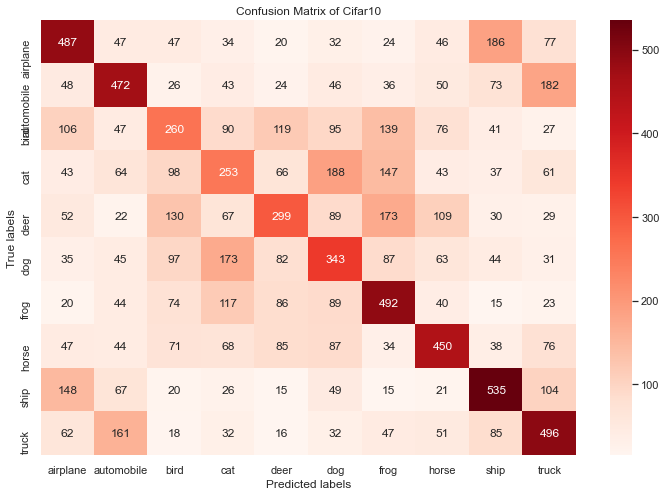

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
plt.subplots(figsize=(12,8))
ax= plt.subplot()

plt.title("Confusion Matrix of Cifar10")
sns.heatmap(confusion_matrix(y_test,predictions), fmt="d",cmap='Reds',annot = True)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(categories); ax.yaxis.set_ticklabels(categories);

Next 36 images in our X_test is tested to evluate how the model performs.As shown below in the first row , the ship is predcted as truck,ship s predicted as airplane frog is predicted as deer and frog is predicted as dog , these are some misclassfied images in the first row , those classified correctly is cat.

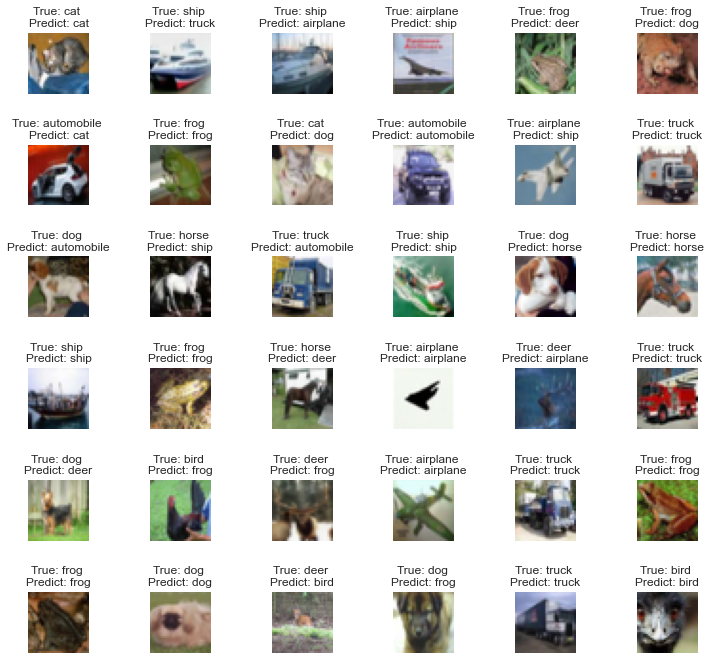

In [35]:

R = 6
C = 6
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(X_test1[i].astype('uint8'), cmap = plt.cm.bone)
    axes[i].set_title("True: %s \nPredict: %s" % (categories[y_test[i]], categories[predictions[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)
plt.show()


#### Refrences:
Pupale,  R.,  2018.Support  Vector  Machines(SVM) —An  Overview.  [online]  Medium.  Available  at: <https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989> [Accessed 11 June 2021].\
Sharma, A., 2020. [online] Available at: <https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python> [Accessed 11 June 2021].\
Yıldırım, S., 2021.Hyperparameter  Tuning  for  Support  Vector  Machines —C  and  Gamma  Parameters. [online]  Medium.  Available  at:  <https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-
10 machines-c-and-   gamma-parameters-6a5097416167> [Accessed 11 June 2021].